# Import

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'raw_data')
data_directory = os.path.abspath(data_directory)
data_directory

'/Users/timjamboula/code/m-r-c-l/Movie-Recommendation-Engine/raw_data'

In [7]:
# Load each CSV file into a DataFrame
links_df = pd.read_csv(os.path.join(data_directory, 'ml-latest-small/links.csv'))
ratings_df = pd.read_csv(os.path.join(data_directory, 'ml-latest-small/ratings.csv'))
tags_df = pd.read_csv(os.path.join(data_directory, 'ml-latest-small/tags.csv'))
movies_df = pd.read_csv(os.path.join(data_directory, 'ml-latest-small/movies.csv'))

In [8]:
# Extracting release year from title
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)')
movies_df['genres'] = movies_df['genres'].str.split('|')
movies_df['title'] = movies_df['title'].str.replace(r'\(\d{4}\)', '').str.strip()

In [9]:
movies_df

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017
9739,193585,Flint (2017),[Drama],2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",2018


In [10]:
print(movies_df.isnull().sum())

movieId     0
title       0
genres      0
year       13
dtype: int64


## Data Cleaning

In [11]:
# Merging ratings with movies - use inner because multiple users rated the movies
ratings_movies_df = pd.merge(ratings_df, movies_df, on='movieId', how='inner')

# Merging ratings_movies with tags
ratings_movies_tags_df = pd.merge(ratings_movies_df, tags_df, on=['movieId', 'userId'], how='left')

# Merging ratings_movies_tags with links
data_df = pd.merge(ratings_movies_tags_df, links_df, on='movieId', how='left')
data_df

,userId,movieId,rating,timestamp_x,title,genres,year,tag,timestamp_y,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,NaN,NaN,114709,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]",1995,NaN,NaN,113228,15602.0
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]",1995,NaN,NaN,113277,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",1995,NaN,NaN,114369,807.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",1995,NaN,NaN,114814,629.0
...,...,...,...,...,...,...,...,...,...,...,...
102672,610,166534,4.0,1493848402,Split (2017),"[Drama, Horror, Thriller]",2017,NaN,NaN,4972582,381288.0
102673,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),"[Action, Crime, Thriller]",2017,Heroic Bloodshed,1.493844e+09,4425200,324552.0
102674,610,168250,5.0,1494273047,Get Out (2017),[Horror],2017,NaN,NaN,5052448,419430.0
102675,610,168252,5.0,1493846352,Logan (2017),"[Action, Sci-Fi]",2017,NaN,NaN,3315342,263115.0


In [12]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       102677 non-null  int64  
 1   movieId      102677 non-null  int64  
 2   rating       102677 non-null  float64
 3   timestamp_x  102677 non-null  int64  
 4   title        102677 non-null  object 
 5   genres       102677 non-null  object 
 6   year         102657 non-null  object 
 7   tag          3476 non-null    object 
 8   timestamp_y  3476 non-null    float64
 9   imdbId       102677 non-null  int64  
 10  tmdbId       102664 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 8.6+ MB


In [13]:
# Filling missing values in 'tag' column with 'Unknown'
data_df['tag'] = data_df['tag'].fillna('Unknown')

In [14]:
import re

# Function to clean the title by removing the year and exclamation marks
def clean_title(title):
    # Removing year
    title = re.sub(r'\(\d{4}\)', '', title)
    # Removing parentheses
    title = title.replace('()', '')
    # Stripping any extra spaces
    return title.strip()

# Applying cleanig function to 'title' column
data_df['title'] = data_df['title'].apply(clean_title)
data_df

,userId,movieId,rating,timestamp_x,title,genres,year,tag,timestamp_y,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Unknown,NaN,114709,862.0
1,1,3,4.0,964981247,Grumpier Old Men,"[Comedy, Romance]",1995,Unknown,NaN,113228,15602.0
2,1,6,4.0,964982224,Heat,"[Action, Crime, Thriller]",1995,Unknown,NaN,113277,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,Unknown,NaN,114369,807.0
4,1,50,5.0,964982931,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,Unknown,NaN,114814,629.0
...,...,...,...,...,...,...,...,...,...,...,...
102672,610,166534,4.0,1493848402,Split,"[Drama, Horror, Thriller]",2017,Unknown,NaN,4972582,381288.0
102673,610,168248,5.0,1493850091,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017,Heroic Bloodshed,1.493844e+09,4425200,324552.0
102674,610,168250,5.0,1494273047,Get Out,[Horror],2017,Unknown,NaN,5052448,419430.0
102675,610,168252,5.0,1493846352,Logan,"[Action, Sci-Fi]",2017,Unknown,NaN,3315342,263115.0


In [15]:
# Converting 'timestamp_x' column to actual dates
data_df['timestamp_x'] = pd.to_datetime(data_df['timestamp_x'], unit='s')
data_df.head()

,userId,movieId,rating,timestamp_x,title,genres,year,tag,timestamp_y,imdbId,tmdbId
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Unknown,NaN,114709,862.0
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,"[Comedy, Romance]",1995,Unknown,NaN,113228,15602.0
2,1,6,4.0,2000-07-30 18:37:04,Heat,"[Action, Crime, Thriller]",1995,Unknown,NaN,113277,949.0
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,Unknown,NaN,114369,807.0
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,Unknown,NaN,114814,629.0


In [16]:
# Dropping 'timestamp_y' - It is unnessecary
data_df = data_df.drop(columns=['timestamp_y'])
data_df.head()

,userId,movieId,rating,timestamp_x,title,genres,year,tag,imdbId,tmdbId
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Unknown,114709,862.0
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,"[Comedy, Romance]",1995,Unknown,113228,15602.0
2,1,6,4.0,2000-07-30 18:37:04,Heat,"[Action, Crime, Thriller]",1995,Unknown,113277,949.0
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,Unknown,114369,807.0
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,Unknown,114814,629.0


In [17]:
# Displaying rows where the 'year' column has missing (NaN) values
rows_with_missing_year = data_df[data_df['year'].isnull()]
rows_with_missing_year

,userId,movieId,rating,timestamp_x,title,genres,year,tag,imdbId,tmdbId
9455,62,176601,5.0,2018-05-08 16:00:52,Black Mirror,[(no genres listed)],NaN,Unknown,2492564,452830.0
17209,105,147250,5.0,2018-05-13 10:29:14,The Adventures of Sherlock Holmes and Doctor W...,[(no genres listed)],NaN,Unknown,229922,127605.0
17236,105,171749,5.0,2018-05-13 10:29:25,Death Note: Desu nôto (2006–2007),[(no genres listed)],NaN,Unknown,877057,419787.0
18202,111,171631,1.0,2018-01-31 23:21:49,Maria Bamford: Old Baby,[(no genres listed)],NaN,Unknown,6264596,455601.0
18204,111,171891,3.5,2018-01-31 23:09:59,Generation Iron 2,[(no genres listed)],NaN,Unknown,6263642,447818.0
30454,209,140956,3.5,2018-04-23 22:23:59,Ready Player One,"[Action, Sci-Fi, Thriller]",NaN,Unknown,1677720,333339.0
30505,210,40697,4.0,2018-05-25 16:36:31,Babylon 5,[Sci-Fi],NaN,Unknown,105946,NaN
47012,305,140956,4.5,2018-07-31 13:26:17,Ready Player One,"[Action, Sci-Fi, Thriller]",NaN,Unknown,1677720,333339.0
47130,306,149334,3.0,2018-02-11 20:19:32,Nocturnal Animals,"[Drama, Thriller]",NaN,Unknown,4550098,340666.0
50293,318,171495,5.0,2018-01-24 20:40:06,Cosmos,[(no genres listed)],NaN,Unknown,81846,409926.0


In [18]:
# Filling in missing ovie years - Dictionary with movieId as key and the correct year as value
year_updates = {
    176601: 2011, 147250: 1984, 171749: 2006, 171631: 2017, 171891: 2017, 140956: 2018, 40697: 1994, 149334: 2016,
    171495: 2016, 167570: 2016, 143410: 2015, 162414: 2016, 156605: 2016}

# Fill in missing years using
for movie_id, correct_year in year_updates.items():
    data_df.loc[data_df['movieId'] == movie_id, 'year'] = correct_year

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   userId       102677 non-null  int64         
 1   movieId      102677 non-null  int64         
 2   rating       102677 non-null  float64       
 3   timestamp_x  102677 non-null  datetime64[ns]
 4   title        102677 non-null  object        
 5   genres       102677 non-null  object        
 6   year         102677 non-null  object        
 7   tag          102677 non-null  object        
 8   imdbId       102677 non-null  int64         
 9   tmdbId       102664 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.8+ MB


In [19]:
# 'year' column to integer
data_df['year'] = data_df['year'].astype(int)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   userId       102677 non-null  int64         
 1   movieId      102677 non-null  int64         
 2   rating       102677 non-null  float64       
 3   timestamp_x  102677 non-null  datetime64[ns]
 4   title        102677 non-null  object        
 5   genres       102677 non-null  object        
 6   year         102677 non-null  int64         
 7   tag          102677 non-null  object        
 8   imdbId       102677 non-null  int64         
 9   tmdbId       102664 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 7.8+ MB


In [20]:
print(data_df.isnull().sum())

userId          0
movieId         0
rating          0
timestamp_x     0
title           0
genres          0
year            0
tag             0
imdbId          0
tmdbId         13
dtype: int64


In [21]:
# Count of total user ratings per movie - Grouping by 'movieId' 
ratings_count = data_df.groupby('movieId').size().reset_index(name='number_of_ratings')

# Merging the ratings count
data_df = pd.merge(data_df, ratings_count, on='movieId', how='left')
data_df

,userId,movieId,rating,timestamp_x,title,genres,year,tag,imdbId,tmdbId,number_of_ratings
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Unknown,114709,862.0,215
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,"[Comedy, Romance]",1995,Unknown,113228,15602.0,53
2,1,6,4.0,2000-07-30 18:37:04,Heat,"[Action, Crime, Thriller]",1995,Unknown,113277,949.0,102
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,Unknown,114369,807.0,204
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,Unknown,114814,629.0,208
...,...,...,...,...,...,...,...,...,...,...,...
102672,610,166534,4.0,2017-05-03 21:53:22,Split,"[Drama, Horror, Thriller]",2017,Unknown,4972582,381288.0,6
102673,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017,Heroic Bloodshed,4425200,324552.0,13
102674,610,168250,5.0,2017-05-08 19:50:47,Get Out,[Horror],2017,Unknown,5052448,419430.0,15
102675,610,168252,5.0,2017-05-03 21:19:12,Logan,"[Action, Sci-Fi]",2017,Unknown,3315342,263115.0,29


In [22]:
# Calculate the mean (average) rating for each movie - Group by 'movieId'
average_ratings = data_df.groupby('movieId')['rating'].mean().round(1).reset_index(name='average_rating')

# Merge the average rating back into the original dataframe
data_df = pd.merge(data_df, average_ratings, on='movieId', how='left')
data_df

,userId,movieId,rating,timestamp_x,title,genres,year,tag,imdbId,tmdbId,number_of_ratings,average_rating
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Unknown,114709,862.0,215,3.9
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,"[Comedy, Romance]",1995,Unknown,113228,15602.0,53,3.2
2,1,6,4.0,2000-07-30 18:37:04,Heat,"[Action, Crime, Thriller]",1995,Unknown,113277,949.0,102,3.9
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,Unknown,114369,807.0,204,4.0
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,Unknown,114814,629.0,208,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...
102672,610,166534,4.0,2017-05-03 21:53:22,Split,"[Drama, Horror, Thriller]",2017,Unknown,4972582,381288.0,6,3.3
102673,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017,Heroic Bloodshed,4425200,324552.0,13,4.3
102674,610,168250,5.0,2017-05-08 19:50:47,Get Out,[Horror],2017,Unknown,5052448,419430.0,15,3.6
102675,610,168252,5.0,2017-05-03 21:19:12,Logan,"[Action, Sci-Fi]",2017,Unknown,3315342,263115.0,29,4.2


In [23]:
# Renaming columns
data_df = data_df.rename(columns={'timestamp_x': 'timestamp'})

#Drop TMBD
data_df = data_df.dropna(axis=1)
data_df

,userId,movieId,rating,timestamp,title,genres,year,tag,imdbId,number_of_ratings,average_rating
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Unknown,114709,215,3.9
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,"[Comedy, Romance]",1995,Unknown,113228,53,3.2
2,1,6,4.0,2000-07-30 18:37:04,Heat,"[Action, Crime, Thriller]",1995,Unknown,113277,102,3.9
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,Unknown,114369,204,4.0
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,Unknown,114814,208,4.3
...,...,...,...,...,...,...,...,...,...,...,...
102672,610,166534,4.0,2017-05-03 21:53:22,Split,"[Drama, Horror, Thriller]",2017,Unknown,4972582,6,3.3
102673,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017,Heroic Bloodshed,4425200,13,4.3
102674,610,168250,5.0,2017-05-08 19:50:47,Get Out,[Horror],2017,Unknown,5052448,15,3.6
102675,610,168252,5.0,2017-05-03 21:19:12,Logan,"[Action, Sci-Fi]",2017,Unknown,3315342,29,4.2


## Exploratory Analysis v001

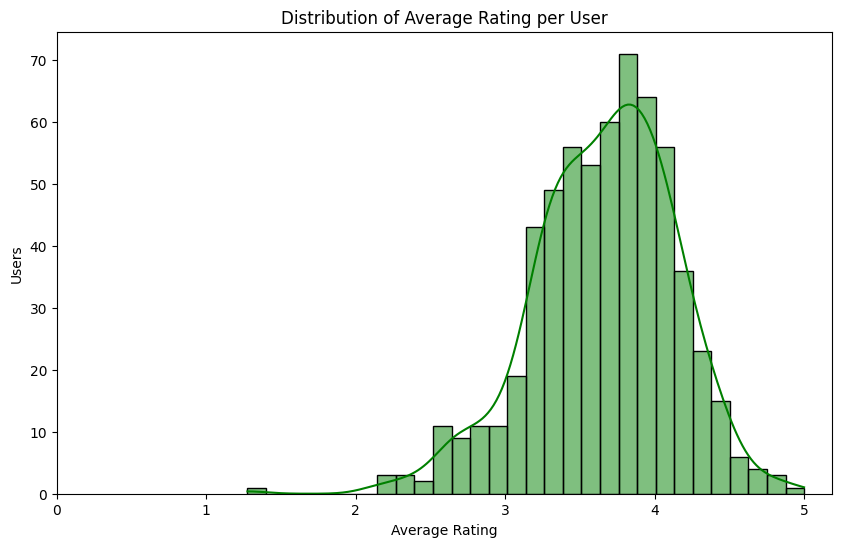

In [24]:
# Average Rating User Has Given to Movies
average_rating_user = data_df.groupby('userId')['rating'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(average_rating_user, bins=30, kde=True, color='green')
plt.title('Distribution of Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Users')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

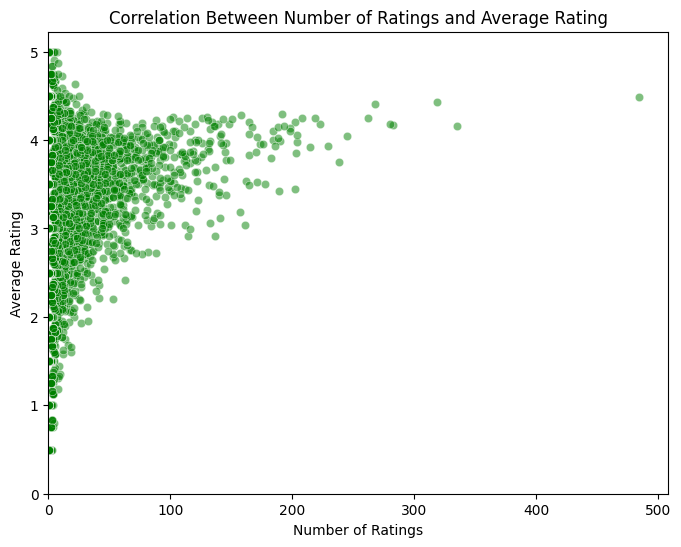

In [25]:
# Correlation Between Number of Ratings and Average Rating. Exploring whether movies with more ratings tend to 
# have higher or lower average ratings.

ratings_per_movie = data_df.groupby('movieId')['rating'].count()
average_rating_per_movie = data_df.groupby('movieId')['rating'].mean()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=ratings_per_movie, y=average_rating_per_movie, alpha=0.5, color='green')
plt.title('Correlation Between Number of Ratings and Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

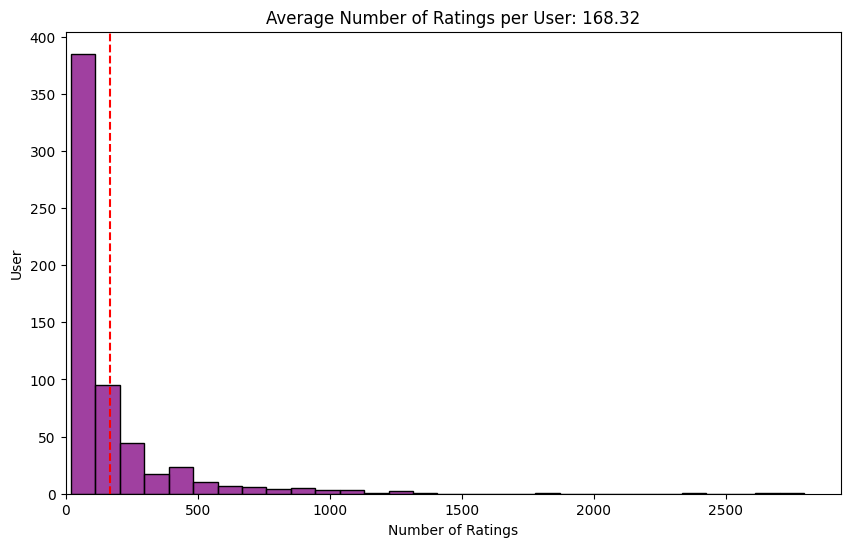

In [26]:
# Average number of ratings per user
ratings_per_user = data_df.groupby('userId')['rating'].count()
average_ratings_per_user = ratings_per_user.mean()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=30, color='purple')
plt.axvline(average_ratings_per_user, color='red', linestyle='--')
plt.title(f'Average Number of Ratings per User: {average_ratings_per_user:.2f}')
plt.xlabel('Number of Ratings')
plt.ylabel('User')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

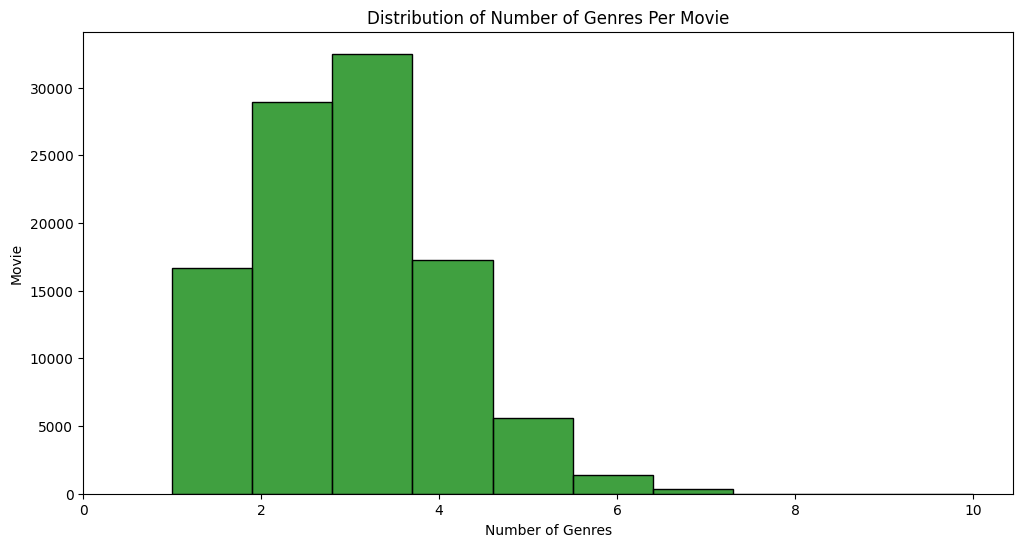

In [27]:
# Multiple Genres per Movie
data_df['num_genres'] = data_df['genres'].apply(lambda x: len(eval('x')))

plt.figure(figsize=(12, 6))
sns.histplot(data_df['num_genres'], bins=10, color='green')
plt.title('Distribution of Number of Genres Per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Movie')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

/var/folders/h2/7np79zrx3xj5tj51tm9hq1zw0000gn/T/ipykernel_23295/3593432989.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genres', y='rating', data=genre_ratings, palette='viridis')


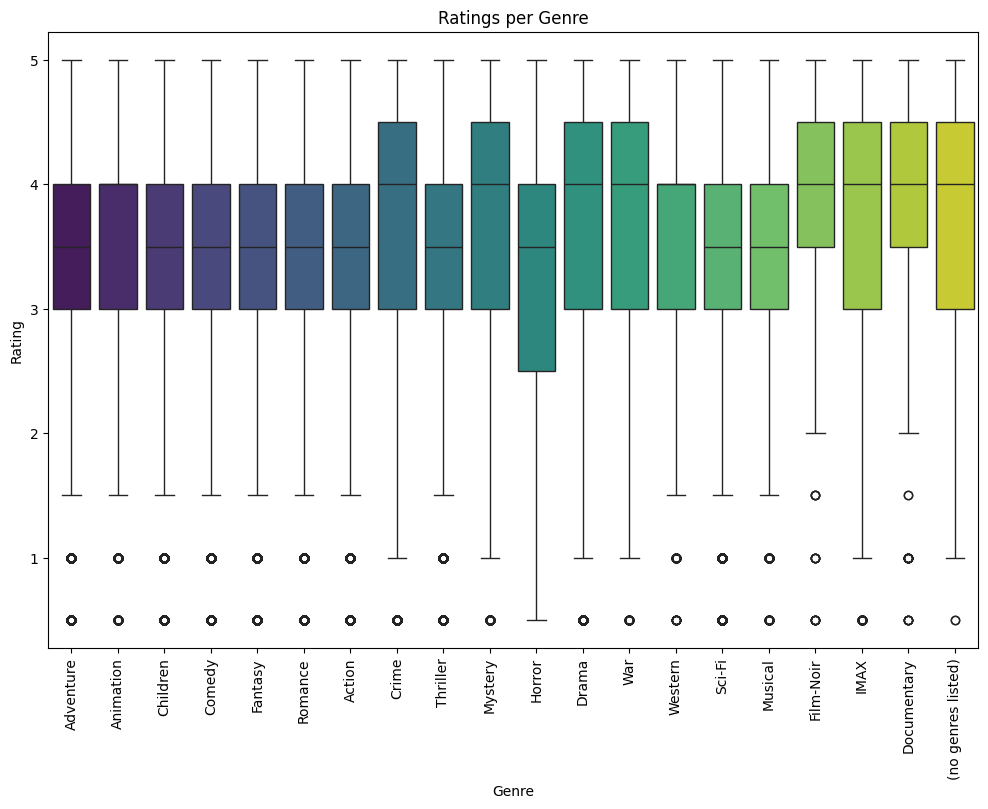

In [28]:
# Ratings per Genre: Distribution of ratings across different genres
genre_ratings = data_df.copy()
genre_ratings['genres'] = genre_ratings['genres'].apply(lambda x: eval('x'))
genre_ratings = genre_ratings.explode('genres')

plt.figure(figsize=(12, 8))
sns.boxplot(x='genres', y='rating', data=genre_ratings, palette='viridis')
plt.title('Ratings per Genre')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.show()

In [29]:
# Splitting genres
genre_ratings = data_df.copy()
genre_ratings['genres'] = genre_ratings['genres'].apply(lambda x: eval('x'))
genre_ratings = genre_ratings.explode('genres')

# Calculating the average rating per genre
avg_rat_genre = genre_ratings.groupby('genres')['rating'].mean().reset_index()
avg_rat_genre.columns = ['genre', 'avg_rat_genre']
avg_rat_genre['avg_rat_genre'] = avg_rat_genre['avg_rat_genre'].round(2)

# Counting the number of movies per genre
movies_per_genre = genre_ratings.groupby('genres')['movieId'].nunique().reset_index()
movies_per_genre.columns = ['genre', 'num_movies_per_genre']

# Counting the number of users per genre
users_per_genre = genre_ratings.groupby('genres')['userId'].nunique().reset_index()
users_per_genre.columns = ['genre', 'num_users_per_genre']

# Merging into one DataFrame
genre_analysis = pd.merge(avg_rat_genre, movies_per_genre, on='genre')
genre_analysis = pd.merge(genre_analysis, users_per_genre, on='genre')

# Calculating the percentage of movies per genre
total_movies = genre_ratings['movieId'].nunique()
genre_analysis['%_total_movies'] = (genre_analysis['num_movies_per_genre'] / total_movies * 100).round(1)
genre_analysis

,genre,avg_rat_genre,num_movies_per_genre,num_users_per_genre,%_total_movies
0,(no genres listed),3.53,34,26,0.3
1,Action,3.46,1828,608,18.8
2,Adventure,3.52,1262,606,13.0
3,Animation,3.64,610,527,6.3
4,Children,3.42,664,559,6.8
5,Comedy,3.40,3753,609,38.6
6,Crime,3.69,1196,603,12.3
7,Documentary,3.81,438,223,4.5
8,Drama,3.67,4349,610,44.7
9,Fantasy,3.50,778,583,8.0


/var/folders/h2/7np79zrx3xj5tj51tm9hq1zw0000gn/T/ipykernel_23295/617182692.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rat_genre', y='genre', data=genre_analysis, palette='Blues_d')


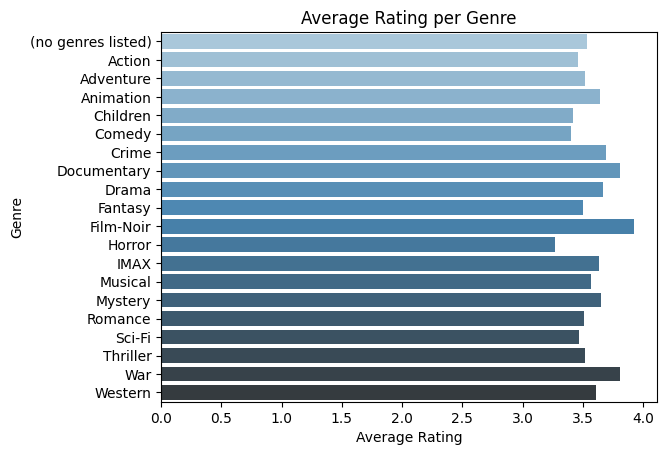

In [30]:
# Average Rating per Genre
sns.barplot(x='avg_rat_genre', y='genre', data=genre_analysis, palette='Blues_d')
plt.title('Average Rating per Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre');

/var/folders/h2/7np79zrx3xj5tj51tm9hq1zw0000gn/T/ipykernel_23295/3404618927.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_movies_per_genre', y='genre', data=genre_analysis, palette='Greens_d')


Text(0, 0.5, 'Genre')

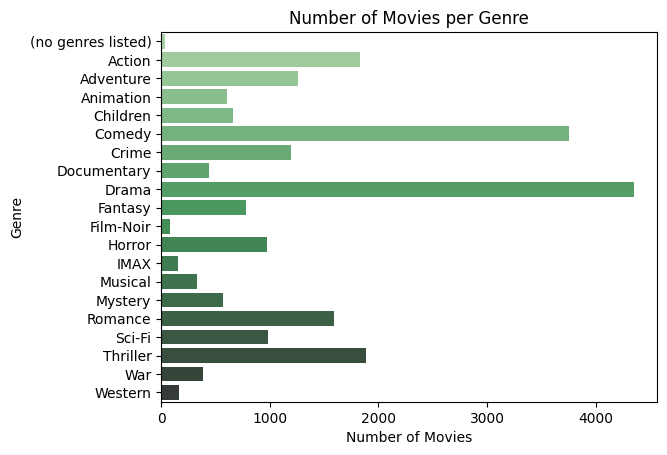

In [31]:
# Number of Movies per Genre
sns.barplot(x='num_movies_per_genre', y='genre', data=genre_analysis, palette='Greens_d')
plt.title('Number of Movies per Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')

/var/folders/h2/7np79zrx3xj5tj51tm9hq1zw0000gn/T/ipykernel_23295/4179274834.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_users_per_genre', y='genre', data=genre_analysis, palette='Oranges_d')


Text(0, 0.5, 'Genre')

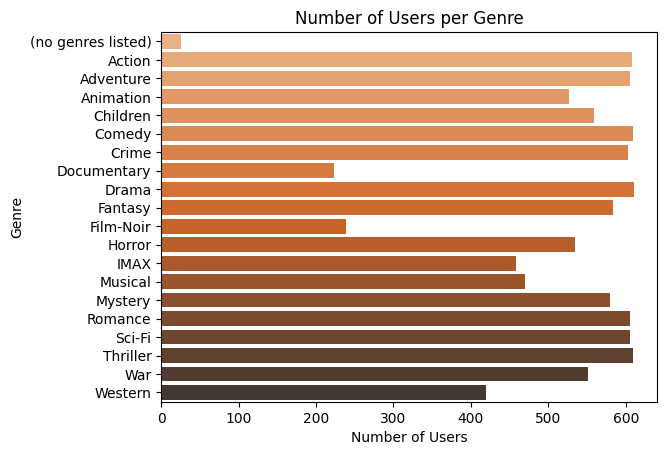

In [32]:
# Number of Users per Genre
sns.barplot(x='num_users_per_genre', y='genre', data=genre_analysis, palette='Oranges_d')
plt.title('Number of Users per Genre')
plt.xlabel('Number of Users')
plt.ylabel('Genre')

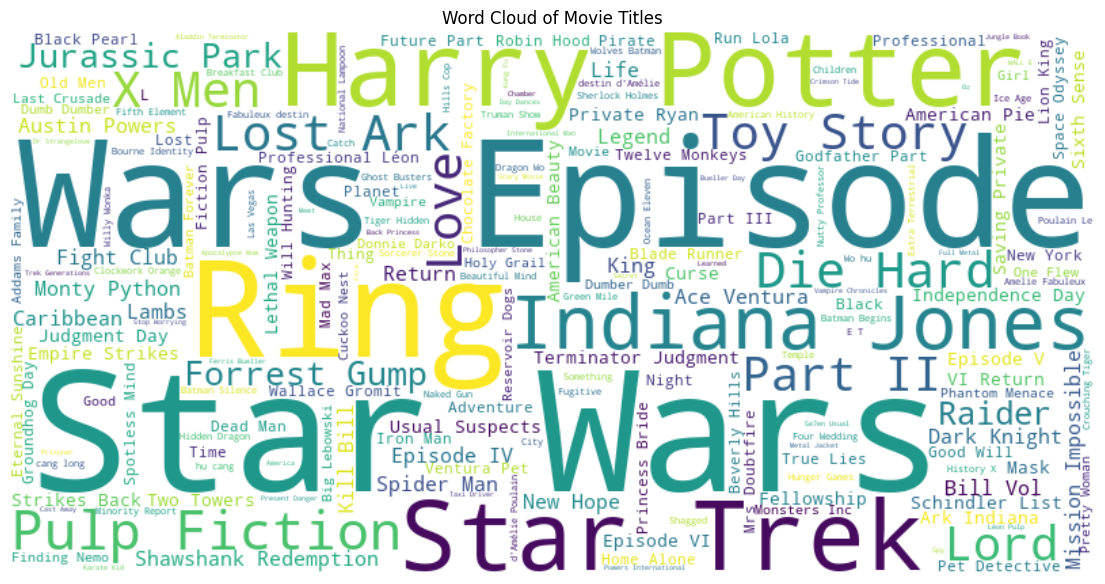

In [33]:
from wordcloud import WordCloud

# Word cloud for movie titles
title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data_df['title']))

plt.figure(figsize=(14, 8))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Movie Titles')
plt.axis('off')
plt.show()

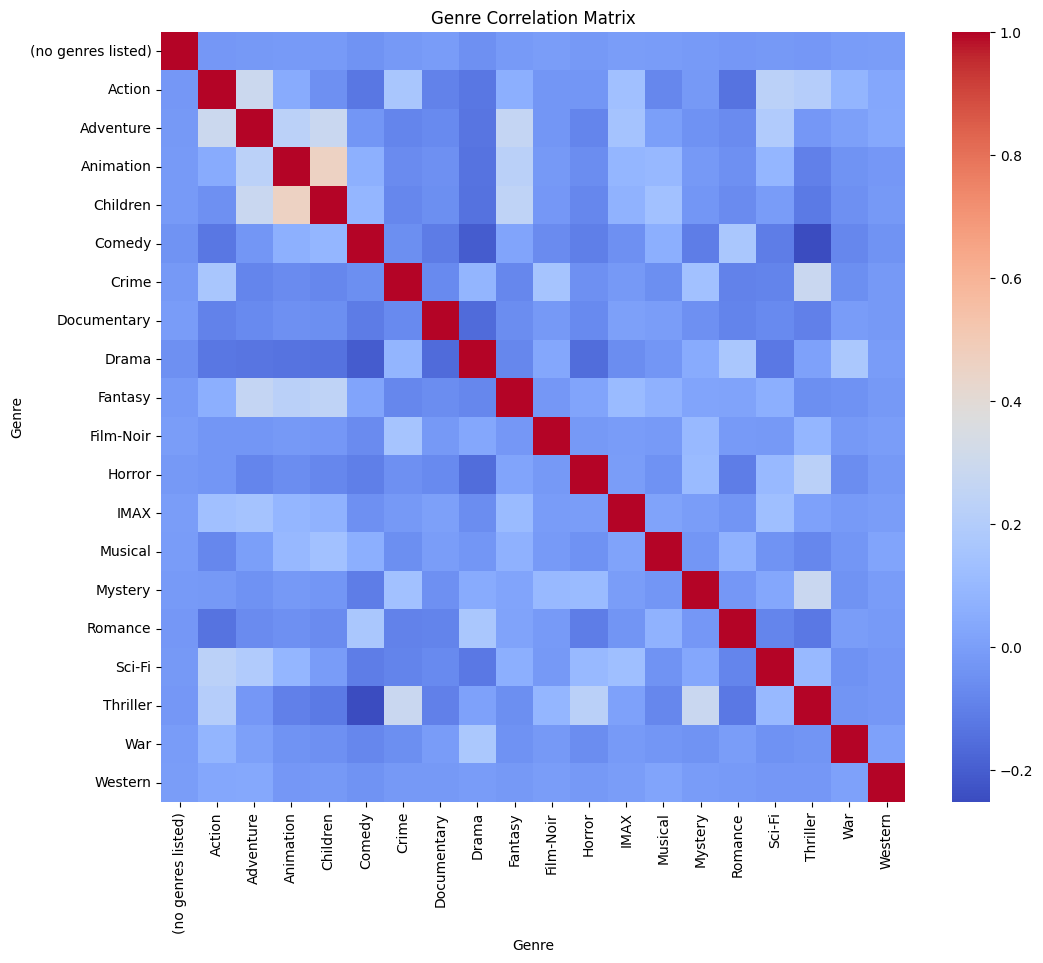

In [34]:
# Genre-movie matrix - Correlations between genres: For example, are users who like “Action” movies also likely 
# to enjoy “Adventure” or “Thriller” genres? Helpful in making cross-genre recommendations?
genre_movie_matrix = genre_ratings.pivot_table(index='movieId', columns='genres', values='rating', aggfunc='mean').fillna(0)

# Calculating correlation between genres
genre_correlation = genre_movie_matrix.corr()

# Plotting correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(genre_correlation, cmap='coolwarm', cbar=True)
plt.title('Genre Correlation Matrix')
plt.xlabel('Genre')
plt.ylabel('Genre')
plt.show()

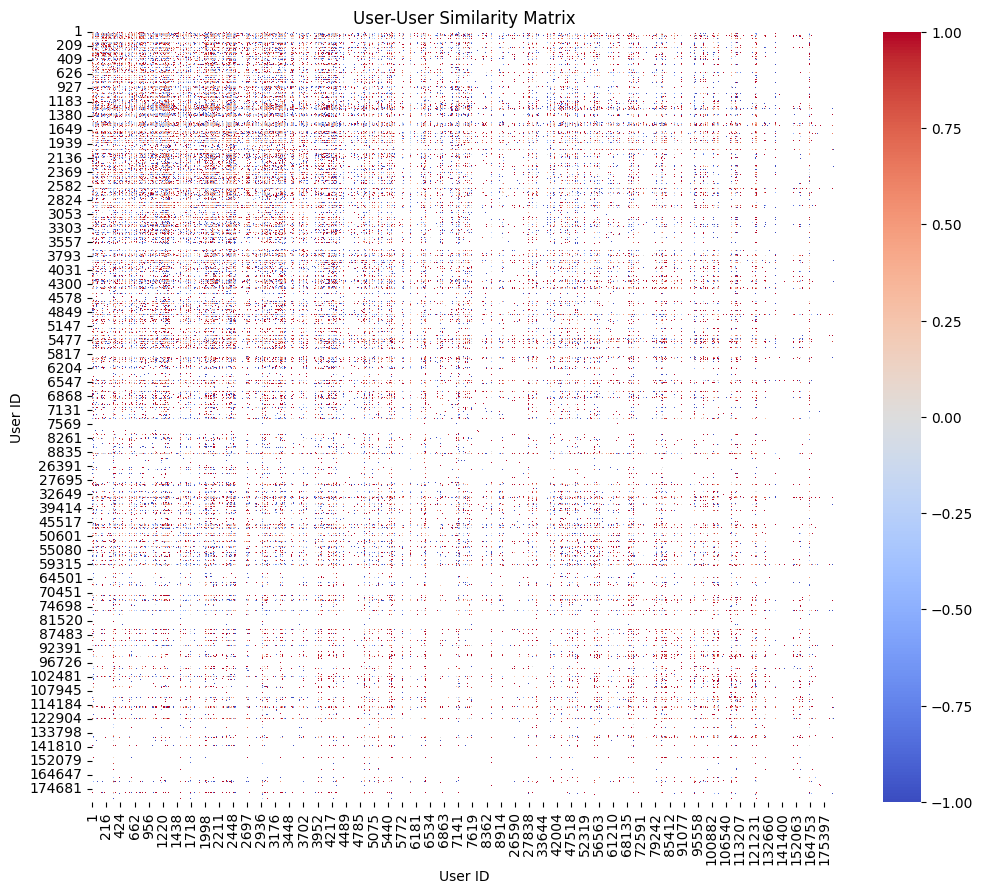

In [35]:
# User-movie rating matrix: Calculate the similarity between users based on their rating patterns. 
# Useful for collaborative filtering-based recommendation systems.
user_movie_matrix = data_df.pivot_table(index='userId', columns='movieId', values='rating')

# Pearson correlation between users
user_similarity = user_movie_matrix.corr(method='pearson')

# Plotting similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(user_similarity, cmap='coolwarm', cbar=True)
plt.title('User-User Similarity Matrix')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.show()

- collaborative: users with similar genre preferences can be grouped together,  
- content-based filtering: recommendations are made based on the user’s historical ratings within certain genres

# IMDB Data Merge

In [37]:
# IMDB File path
file_path = '/Users/timjamboula/Documents/Movie-Recommendation-Engine/raw_data/ml-latest-small/TMDB_all_movies.csv'
imdb_df = pd.read_csv(file_path)

imdb_df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes
0,2,Ariel,7.100,327.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,Finland,suomi,"Eino Kuusela, Timo Harakka, Sirkka Rautiainen,...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Aki Kaurismäki,NaN,7.4,8635.0
1,3,Shadows in Paradise,7.300,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,Finland,"suomi, English, svenska","Kati Outinen, Ulla Kuosmanen, Jaakko Talaskivi...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Mika Kaurismäki,NaN,7.5,7371.0
2,5,Four Rooms,5.800,2593.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,United States of America,English,"Jennifer Beals, Sammi Davis, Ione Skye, Paul C...","Allison Anders, Quentin Tarantino, Alexandre R...","Andrzej Sekula, Rodrigo García, Guillermo Nava...","Alexandre Rockwell, Allison Anders, Quentin Ta...","Alexandre Rockwell, Quentin Tarantino, Lawrenc...",Combustible Edison,6.7,111991.0
3,6,Judgment Night,6.483,329.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,United States of America,English,"Kathleen Perkins, Relioues Webb, Emilio Esteve...",Stephen Hopkins,Peter Levy,"Jere Cunningham, Lewis Colick","Marilyn Vance, Lloyd Segan, Gene Levy",Alan Silvestri,6.6,19114.0
4,8,Life in Loops (A Megacities RMX),7.500,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,Austria,"English, हिन्दी, 日本語, Pусский, Español",NaN,Timo Novotny,Wolfgang Thaler,"Michael Glawogger, Timo Novotny","Ulrich Gehmacher, Timo Novotny",NaN,8.2,283.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979802,1342437,Dead Leaf Moth,0.000,0.0,Released,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979803,1342438,The Farm,0.000,0.0,Released,NaN,0.0,19.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979804,1342439,Hickey,0.000,0.0,Released,NaN,0.0,19.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979805,2662126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"Johannes Allmayer, Jules Waringo, Vicky Krieps...",Florian Gallenberger,Kolja Brandt,"Florian Gallenberger, Torsten Wenzel, Tom Kinn...","Nicolas Steil, Benjamin Herrmann",NaN,NaN,NaN


In [38]:
# Cleaning imdb_id by removing all variations of 'tt', 'tt0', 'tt00', etc.
def clean_imdb_id(imdb_id):
    # Converting the value to string
    imdb_id_str = str(imdb_id)
    cleaned_id = imdb_id.lstrip('tt0')
    cleaned_id = imdb_id.lstrip('tt00')
    cleaned_id = imdb_id.lstrip('tt000')
    cleaned_id = imdb_id.lstrip('tt0000')
    cleaned_id = imdb_id.lstrip('tt00000')
    cleaned_id = imdb_id.lstrip('tt000000')
    return cleaned_id

# imdb_id column to string
imdb_df['imdb_id'] = imdb_df['imdb_id'].astype(str)

# Apply
imdb_df['imdb_cleaned'] = imdb_df['imdb_id'].apply(clean_imdb_id)
imdb_df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,imdb_cleaned
0,2,Ariel,7.100,327.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,suomi,"Eino Kuusela, Timo Harakka, Sirkka Rautiainen,...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Aki Kaurismäki,NaN,7.4,8635.0,94675
1,3,Shadows in Paradise,7.300,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,"suomi, English, svenska","Kati Outinen, Ulla Kuosmanen, Jaakko Talaskivi...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Mika Kaurismäki,NaN,7.5,7371.0,92149
2,5,Four Rooms,5.800,2593.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,English,"Jennifer Beals, Sammi Davis, Ione Skye, Paul C...","Allison Anders, Quentin Tarantino, Alexandre R...","Andrzej Sekula, Rodrigo García, Guillermo Nava...","Alexandre Rockwell, Allison Anders, Quentin Ta...","Alexandre Rockwell, Quentin Tarantino, Lawrenc...",Combustible Edison,6.7,111991.0,113101
3,6,Judgment Night,6.483,329.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,English,"Kathleen Perkins, Relioues Webb, Emilio Esteve...",Stephen Hopkins,Peter Levy,"Jere Cunningham, Lewis Colick","Marilyn Vance, Lloyd Segan, Gene Levy",Alan Silvestri,6.6,19114.0,107286
4,8,Life in Loops (A Megacities RMX),7.500,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,"English, हिन्दी, 日本語, Pусский, Español",NaN,Timo Novotny,Wolfgang Thaler,"Michael Glawogger, Timo Novotny","Ulrich Gehmacher, Timo Novotny",NaN,8.2,283.0,825671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979802,1342437,Dead Leaf Moth,0.000,0.0,Released,NaN,0.0,0.0,0.0,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
979803,1342438,The Farm,0.000,0.0,Released,NaN,0.0,19.0,0.0,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
979804,1342439,Hickey,0.000,0.0,Released,NaN,0.0,19.0,0.0,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
979805,2662126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,NaN,"Johannes Allmayer, Jules Waringo, Vicky Krieps...",Florian Gallenberger,Kolja Brandt,"Florian Gallenberger, Torsten Wenzel, Tom Kinn...","Nicolas Steil, Benjamin Herrmann",NaN,NaN,NaN,nan


In [39]:
# Dropping 'timestamp_y' - It is unnessecary
imdb_df = imdb_df.drop(columns=["id"])
imdb_df = imdb_df.drop(columns=["status"])
imdb_df = imdb_df.drop(columns=["release_date"])
imdb_df = imdb_df.drop(columns=["original_language"])
imdb_df = imdb_df.drop(columns=["original_title"])
imdb_df = imdb_df.drop(columns=["production_companies"])
imdb_df = imdb_df.drop(columns=["production_countries"])
imdb_df = imdb_df.drop(columns=["director_of_photography"])
imdb_df = imdb_df.drop(columns=["writers"])
imdb_df = imdb_df.drop(columns=["producers"])
imdb_df = imdb_df.drop(columns=["music_composer"])
imdb_df.head()

,title,vote_average,vote_count,revenue,runtime,budget,imdb_id,overview,popularity,tagline,genres,spoken_languages,cast,director,imdb_rating,imdb_votes,imdb_cleaned
0,Ariel,7.100,327.0,0.0,73.0,0.0,tt0094675,After the coal mine he works at closes and his...,31.143,NaN,"Comedy, Drama, Romance, Crime",suomi,"Eino Kuusela, Timo Harakka, Sirkka Rautiainen,...",Aki Kaurismäki,7.4,8635.0,94675
1,Shadows in Paradise,7.300,369.0,0.0,74.0,0.0,tt0092149,"Nikander, a rubbish collector and would-be ent...",16.287,NaN,"Comedy, Drama, Romance","suomi, English, svenska","Kati Outinen, Ulla Kuosmanen, Jaakko Talaskivi...",Aki Kaurismäki,7.5,7371.0,92149
2,Four Rooms,5.800,2593.0,4257354.0,98.0,4000000.0,tt0113101,It's Ted the Bellhop's first night on the job....,19.383,Twelve outrageous guests. Four scandalous requ...,Comedy,English,"Jennifer Beals, Sammi Davis, Ione Skye, Paul C...","Allison Anders, Quentin Tarantino, Alexandre R...",6.7,111991.0,113101
3,Judgment Night,6.483,329.0,12136938.0,109.0,21000000.0,tt0107286,"Four young friends, while taking a shortcut en...",13.344,Don't move. Don't whisper. Don't even breathe.,"Action, Crime, Thriller",English,"Kathleen Perkins, Relioues Webb, Emilio Esteve...",Stephen Hopkins,6.6,19114.0,107286
4,Life in Loops (A Megacities RMX),7.500,27.0,0.0,80.0,42000.0,tt0825671,Timo Novotny labels his new project an experim...,3.203,A Megacities remix.,Documentary,"English, हिन्दी, 日本語, Pусский, Español",NaN,Timo Novotny,8.2,283.0,825671


In [40]:
# Renaming
imdb_df = imdb_df.rename(columns={'imdb_cleaned': 'imdbId'})
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979807 entries, 0 to 979806
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   title             979798 non-null  object 
 1   vote_average      979805 non-null  float64
 2   vote_count        979805 non-null  float64
 3   revenue           979805 non-null  float64
 4   runtime           979805 non-null  float64
 5   budget            979805 non-null  float64
 6   imdb_id           979807 non-null  object 
 7   overview          811782 non-null  object 
 8   popularity        979805 non-null  float64
 9   tagline           145296 non-null  object 
 10  genres            696352 non-null  object 
 11  spoken_languages  605146 non-null  object 
 12  cast              656546 non-null  object 
 13  director          806089 non-null  object 
 14  imdb_rating       420663 non-null  float64
 15  imdb_votes        420663 non-null  float64
 16  imdbId            97

In [41]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   userId             102677 non-null  int64         
 1   movieId            102677 non-null  int64         
 2   rating             102677 non-null  float64       
 3   timestamp          102677 non-null  datetime64[ns]
 4   title              102677 non-null  object        
 5   genres             102677 non-null  object        
 6   year               102677 non-null  int64         
 7   tag                102677 non-null  object        
 8   imdbId             102677 non-null  int64         
 9   number_of_ratings  102677 non-null  int64         
 10  average_rating     102677 non-null  float64       
 11  num_genres         102677 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 9.4+ MB


In [42]:
# Changing that both 'imdbId' to same data type (string)
data_df['imdbId'] = data_df['imdbId'].astype(str)
imdb_df['imdbId'] = imdb_df['imdbId'].astype(str)

# Merging
imdb_merged_data = pd.merge(data_df, imdb_df, on='imdbId', how='left')
imdb_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102688 entries, 0 to 102687
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   userId             102688 non-null  int64         
 1   movieId            102688 non-null  int64         
 2   rating             102688 non-null  float64       
 3   timestamp          102688 non-null  datetime64[ns]
 4   title_x            102688 non-null  object        
 5   genres_x           102688 non-null  object        
 6   year               102688 non-null  int64         
 7   tag                102688 non-null  object        
 8   imdbId             102688 non-null  object        
 9   number_of_ratings  102688 non-null  int64         
 10  average_rating     102688 non-null  float64       
 11  num_genres         102688 non-null  int64         
 12  title_y            102439 non-null  object        
 13  vote_average       102439 non-null  float64 

In [43]:
# Displaying the 11 newly added rows
new_rows = imdb_merged_data.loc[~imdb_merged_data.index.isin(data_df.index)]
new_rows

,userId,movieId,rating,timestamp,title_x,genres_x,year,tag,imdbId,number_of_ratings,...,imdb_id,overview,popularity,tagline,genres_y,spoken_languages,cast,director,imdb_rating,imdb_votes
102677,610,161634,4.0,2017-05-03 21:52:42,Don't Breathe,[Thriller],2016,Unknown,4160708,5,...,tt4160708,A group of teens break into a blind man's home...,61.131,"This house looked like an easy target, until t...","Horror, Thriller",English,"Dylan Minnette, Stephen Lang, Franciska Törőcs...",Fede Álvarez,7.1,306797.0
102678,610,162350,3.5,2017-05-03 22:19:31,The Magnificent Seven,"[Action, Western]",2016,Unknown,2404435,6,...,tt2404435,"Looking to mine for gold, greedy industrialist...",54.382,Justice has a number.,"Adventure, Action, Western","English, Italiano","Peter Sarsgaard, Manuel Garcia-Rulfo, Ed Lowry...",Antoine Fuqua,6.9,231531.0
102679,610,163937,3.5,2017-05-03 21:59:49,Blair Witch,"[Horror, Thriller]",2016,Unknown,1540011,1,...,tt1540011,Students on a camping trip discover something ...,23.043,There's something evil hiding in the woods.,"Thriller, Horror",English,"Wes Robinson, James Allen McCune, Corbin Reid,...",Adam Wingard,5.0,50359.0
102680,610,163981,3.5,2017-05-03 22:22:35,31,[Horror],2016,Unknown,3835080,1,...,tt3835080,Five carnival workers are kidnapped and held h...,12.705,Welcome to hell.,"Horror, Thriller","Deutsch, English, Español","Gabriel Pimentel, Megan Albertus, Daniel Roebu...",Rob Zombie,5.1,23282.0
102681,610,164179,5.0,2017-05-03 21:07:11,Arrival,[Sci-Fi],2016,Unknown,2543164,32,...,tt2543164,Taking place after alien crafts land around th...,54.640,Why are they here?,"Drama, Science Fiction, Mystery","普通话, English, Pусский","Christian Jadah, Leisa Reid, Ruth Chiang, Lori...",Denis Villeneuve,7.9,785997.0
102682,610,166528,4.0,2017-05-04 06:29:25,Rogue One: A Star Wars Story,"[Action, Adventure, Fantasy, Sci-Fi]",2016,Unknown,3748528,27,...,tt3748528,A rogue band of resistance fighters unite for ...,43.491,A rebellion built on hope.,"Action, Adventure, Science Fiction",English,"Daniel Mays, John S. Schwartz, Warwick Davis, ...",Gareth Edwards,7.8,696658.0
102683,610,166534,4.0,2017-05-03 21:53:22,Split,"[Drama, Horror, Thriller]",2017,Unknown,4972582,6,...,tt4972582,Though Kevin has evidenced 23 personalities to...,70.505,Kevin has 23 distinct personalities. The 24th ...,"Horror, Thriller",English,"John Jillard Sr., Jerome Gallman, Ann Wood, Al...",M. Night Shyamalan,7.3,566678.0
102684,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017,Heroic Bloodshed,4425200,13,...,tt4425200,John Wick is forced out of retirement by a for...,101.664,Never stab the devil in the back!,"Action, Thriller, Crime","English, עִבְרִית, Italiano, Pусский","Thaddeus Daniels, Tim Connolly, Nobuya Shimamo...",Chad Stahelski,7.4,521063.0
102685,610,168250,5.0,2017-05-08 19:50:47,Get Out,[Horror],2017,Unknown,5052448,15,...,tt5052448,Chris and his girlfriend Rose go upstate to vi...,66.339,"Just because you're invited, doesn't mean you'...","Mystery, Thriller, Horror",English,"Bradley Whitford, Lil Rel Howery, Keegan-Micha...",Jordan Peele,7.8,720999.0
102686,610,168252,5.0,2017-05-03 21:19:12,Logan,"[Action, Sci-Fi]",2017,Unknown,3315342,29,...,tt3315342,"In the near future, a weary Logan cares for an...",159.281,His time has come.,"Action, Drama, Science Fiction","English, Español","Bryant Tardy, Daniel Hernández, Krzysztof Sosz...",James Mangold,8.1,856843.0


In [44]:
# Finding the duplicate rows based on the 'imdbId' column
duplicate_rows = imdb_merged_data[imdb_merged_data['imdbId'].duplicated(keep=False)]
duplicate_rows

,userId,movieId,rating,timestamp,title_x,genres_x,year,tag,imdbId,number_of_ratings,...,imdb_id,overview,popularity,tagline,genres_y,spoken_languages,cast,director,imdb_rating,imdb_votes
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Unknown,114709,215,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Animation, Adventure, Family, Comedy",English,"Penn Jillette, Jim Varney, Annie Potts, John L...",John Lasseter,8.3,1084026.0
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,"[Comedy, Romance]",1995,Unknown,113228,53,...,tt0113228,A family wedding reignites the ancient feud be...,11.833,Still Yelling. Still Fighting. Still Ready for...,"Romance, Comedy",English,"Sophia Loren, Jack Lemmon, Burgess Meredith, W...",Howard Deutch,6.7,30004.0
2,1,6,4.0,2000-07-30 18:37:04,Heat,"[Action, Crime, Thriller]",1995,Unknown,113277,102,...,tt0113277,Obsessive master thief Neil McCauley leads a t...,48.869,A Los Angeles crime saga.,"Action, Crime, Drama","English, Español","Henry Rollins, Rick Marzan, Mick Gould, Kai So...",Michael Mann,8.3,729795.0
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,Unknown,114369,204,...,tt0114369,Two homicide detectives are on a desperate hun...,108.020,Seven deadly sins. Seven ways to die.,"Crime, Mystery, Thriller",English,"Shannon Wilcox, Hawthorne James, Allan Kolman,...",David Fincher,8.6,1829387.0
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,Unknown,114814,208,...,tt0114814,"Held in an L.A. interrogation room, Verbal Kin...",41.143,Five criminals. One line up. No coincidence.,"Drama, Crime, Thriller","Español, English, Français, Magyar","Dan Hedaya, Gabriel Byrne, Stephen Baldwin, Gi...",Bryan Singer,8.5,1157914.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102683,610,166534,4.0,2017-05-03 21:53:22,Split,"[Drama, Horror, Thriller]",2017,Unknown,4972582,6,...,tt4972582,Though Kevin has evidenced 23 personalities to...,70.505,Kevin has 23 distinct personalities. The 24th ...,"Horror, Thriller",English,"John Jillard Sr., Jerome Gallman, Ann Wood, Al...",M. Night Shyamalan,7.3,566678.0
102684,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017,Heroic Bloodshed,4425200,13,...,tt4425200,John Wick is forced out of retirement by a for...,101.664,Never stab the devil in the back!,"Action, Thriller, Crime","English, עִבְרִית, Italiano, Pусский","Thaddeus Daniels, Tim Connolly, Nobuya Shimamo...",Chad Stahelski,7.4,521063.0
102685,610,168250,5.0,2017-05-08 19:50:47,Get Out,[Horror],2017,Unknown,5052448,15,...,tt5052448,Chris and his girlfriend Rose go upstate to vi...,66.339,"Just because you're invited, doesn't mean you'...","Mystery, Thriller, Horror",English,"Bradley Whitford, Lil Rel Howery, Keegan-Micha...",Jordan Peele,7.8,720999.0
102686,610,168252,5.0,2017-05-03 21:19:12,Logan,"[Action, Sci-Fi]",2017,Unknown,3315342,29,...,tt3315342,"In the near future, a weary Logan cares for an...",159.281,His time has come.,"Action, Drama, Science Fiction","English, Español","Bryant Tardy, Daniel Hernández, Krzysztof Sosz...",James Mangold,8.1,856843.0


In [45]:
# Counting duplicates in each column
def count_duplicates(df):
    duplicates_count = {}
    for column in df.columns:
        duplicates_count[column] = df.duplicated(subset=[column]).sum()
    return duplicates_count

# Counting duplicates in data_df
data_df_duplicates = count_duplicates(data_df)
print("Duplicates in data_df:")
print(data_df_duplicates)

# Counting duplicates in imdb_data
imdb_df_duplicates = count_duplicates(imdb_df)
print("\nDuplicates in imdb_df:")
print(imdb_df_duplicates)

# Counting duplicates in imdb_data
imdb_merged_df_duplicates = count_duplicates(imdb_merged_data)
print("\nDuplicates in imdb_merged_data:")
print(imdb_merged_df_duplicates)

Duplicates in data_df:
{'userId': 102067, 'movieId': 92953, 'rating': 102667, 'timestamp': 17634, 'title': 93231, 'genres': 101726, 'year': 102571, 'tag': 101133, 'imdbId': 92953, 'number_of_ratings': 102497, 'average_rating': 102634, 'num_genres': 102668}

Duplicates in imdb_df:
{'title': 144001, 'vote_average': 975590, 'vote_count': 976035, 'revenue': 964165, 'runtime': 979088, 'budget': 974012, 'imdb_id': 402650, 'overview': 186354, 'popularity': 953221, 'tagline': 838617, 'genres': 965814, 'spoken_languages': 973139, 'cast': 365866, 'director': 653351, 'imdb_rating': 979715, 'imdb_votes': 960632, 'imdbId': 402650}

Duplicates in imdb_merged_data:
{'userId': 102078, 'movieId': 92964, 'rating': 102678, 'timestamp': 17645, 'title_x': 93242, 'genres_x': 101737, 'year': 102582, 'tag': 101144, 'imdbId': 92964, 'number_of_ratings': 102508, 'average_rating': 102645, 'num_genres': 102679, 'title_y': 93371, 'vote_average': 100513, 'vote_count': 99404, 'revenue': 96932, 'runtime': 102464, 'bu

In [46]:
# Replacing 'Unknown' with NaN in the 'tag' & 'tagline' column
imdb_merged_data['tag'] = imdb_merged_data['tag'].replace('Unknown', '')
imdb_merged_data['tagline'] = imdb_merged_data['tagline'].replace('NaN', '')
imdb_merged_data

,userId,movieId,rating,timestamp,title_x,genres_x,year,tag,imdbId,number_of_ratings,...,imdb_id,overview,popularity,tagline,genres_y,spoken_languages,cast,director,imdb_rating,imdb_votes
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,,114709,215,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Animation, Adventure, Family, Comedy",English,"Penn Jillette, Jim Varney, Annie Potts, John L...",John Lasseter,8.3,1084026.0
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,"[Comedy, Romance]",1995,,113228,53,...,tt0113228,A family wedding reignites the ancient feud be...,11.833,Still Yelling. Still Fighting. Still Ready for...,"Romance, Comedy",English,"Sophia Loren, Jack Lemmon, Burgess Meredith, W...",Howard Deutch,6.7,30004.0
2,1,6,4.0,2000-07-30 18:37:04,Heat,"[Action, Crime, Thriller]",1995,,113277,102,...,tt0113277,Obsessive master thief Neil McCauley leads a t...,48.869,A Los Angeles crime saga.,"Action, Crime, Drama","English, Español","Henry Rollins, Rick Marzan, Mick Gould, Kai So...",Michael Mann,8.3,729795.0
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,,114369,204,...,tt0114369,Two homicide detectives are on a desperate hun...,108.020,Seven deadly sins. Seven ways to die.,"Crime, Mystery, Thriller",English,"Shannon Wilcox, Hawthorne James, Allan Kolman,...",David Fincher,8.6,1829387.0
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,,114814,208,...,tt0114814,"Held in an L.A. interrogation room, Verbal Kin...",41.143,Five criminals. One line up. No coincidence.,"Drama, Crime, Thriller","Español, English, Français, Magyar","Dan Hedaya, Gabriel Byrne, Stephen Baldwin, Gi...",Bryan Singer,8.5,1157914.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102683,610,166534,4.0,2017-05-03 21:53:22,Split,"[Drama, Horror, Thriller]",2017,,4972582,6,...,tt4972582,Though Kevin has evidenced 23 personalities to...,70.505,Kevin has 23 distinct personalities. The 24th ...,"Horror, Thriller",English,"John Jillard Sr., Jerome Gallman, Ann Wood, Al...",M. Night Shyamalan,7.3,566678.0
102684,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017,Heroic Bloodshed,4425200,13,...,tt4425200,John Wick is forced out of retirement by a for...,101.664,Never stab the devil in the back!,"Action, Thriller, Crime","English, עִבְרִית, Italiano, Pусский","Thaddeus Daniels, Tim Connolly, Nobuya Shimamo...",Chad Stahelski,7.4,521063.0
102685,610,168250,5.0,2017-05-08 19:50:47,Get Out,[Horror],2017,,5052448,15,...,tt5052448,Chris and his girlfriend Rose go upstate to vi...,66.339,"Just because you're invited, doesn't mean you'...","Mystery, Thriller, Horror",English,"Bradley Whitford, Lil Rel Howery, Keegan-Micha...",Jordan Peele,7.8,720999.0
102686,610,168252,5.0,2017-05-03 21:19:12,Logan,"[Action, Sci-Fi]",2017,,3315342,29,...,tt3315342,"In the near future, a weary Logan cares for an...",159.281,His time has come.,"Action, Drama, Science Fiction","English, Español","Bryant Tardy, Daniel Hernández, Krzysztof Sosz...",James Mangold,8.1,856843.0


In [47]:
# Merging 'tag' and 'tagline'
#imdb_merged_data['merged_tag'] = imdb_merged_data.apply(
#    lambda row: (
#        row['tag'] if row['tag'] and row['tagline'] == '' else
#        row['tagline'] if row['tagline'] and row['tag'] == '' else
#        ', '.join([str(row['tag']), str(row['tagline'])]).strip(', ') if row['tag'] and row['tagline'] else
#        'Unknown'
#    ), axis=1)
#
#imdb_merged_data

In [48]:
# Genres to String
imdb_merged_data['genres_x'] = imdb_merged_data['genres_x'].apply(lambda x: ', '.join(x) if x else 'Unknown')
imdb_merged_data

,userId,movieId,rating,timestamp,title_x,genres_x,year,tag,imdbId,number_of_ratings,...,imdb_id,overview,popularity,tagline,genres_y,spoken_languages,cast,director,imdb_rating,imdb_votes
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,"Adventure, Animation, Children, Comedy, Fantasy",1995,,114709,215,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Animation, Adventure, Family, Comedy",English,"Penn Jillette, Jim Varney, Annie Potts, John L...",John Lasseter,8.3,1084026.0
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,"Comedy, Romance",1995,,113228,53,...,tt0113228,A family wedding reignites the ancient feud be...,11.833,Still Yelling. Still Fighting. Still Ready for...,"Romance, Comedy",English,"Sophia Loren, Jack Lemmon, Burgess Meredith, W...",Howard Deutch,6.7,30004.0
2,1,6,4.0,2000-07-30 18:37:04,Heat,"Action, Crime, Thriller",1995,,113277,102,...,tt0113277,Obsessive master thief Neil McCauley leads a t...,48.869,A Los Angeles crime saga.,"Action, Crime, Drama","English, Español","Henry Rollins, Rick Marzan, Mick Gould, Kai So...",Michael Mann,8.3,729795.0
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),"Mystery, Thriller",1995,,114369,204,...,tt0114369,Two homicide detectives are on a desperate hun...,108.020,Seven deadly sins. Seven ways to die.,"Crime, Mystery, Thriller",English,"Shannon Wilcox, Hawthorne James, Allan Kolman,...",David Fincher,8.6,1829387.0
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The","Crime, Mystery, Thriller",1995,,114814,208,...,tt0114814,"Held in an L.A. interrogation room, Verbal Kin...",41.143,Five criminals. One line up. No coincidence.,"Drama, Crime, Thriller","Español, English, Français, Magyar","Dan Hedaya, Gabriel Byrne, Stephen Baldwin, Gi...",Bryan Singer,8.5,1157914.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102683,610,166534,4.0,2017-05-03 21:53:22,Split,"Drama, Horror, Thriller",2017,,4972582,6,...,tt4972582,Though Kevin has evidenced 23 personalities to...,70.505,Kevin has 23 distinct personalities. The 24th ...,"Horror, Thriller",English,"John Jillard Sr., Jerome Gallman, Ann Wood, Al...",M. Night Shyamalan,7.3,566678.0
102684,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,"Action, Crime, Thriller",2017,Heroic Bloodshed,4425200,13,...,tt4425200,John Wick is forced out of retirement by a for...,101.664,Never stab the devil in the back!,"Action, Thriller, Crime","English, עִבְרִית, Italiano, Pусский","Thaddeus Daniels, Tim Connolly, Nobuya Shimamo...",Chad Stahelski,7.4,521063.0
102685,610,168250,5.0,2017-05-08 19:50:47,Get Out,Horror,2017,,5052448,15,...,tt5052448,Chris and his girlfriend Rose go upstate to vi...,66.339,"Just because you're invited, doesn't mean you'...","Mystery, Thriller, Horror",English,"Bradley Whitford, Lil Rel Howery, Keegan-Micha...",Jordan Peele,7.8,720999.0
102686,610,168252,5.0,2017-05-03 21:19:12,Logan,"Action, Sci-Fi",2017,,3315342,29,...,tt3315342,"In the near future, a weary Logan cares for an...",159.281,His time has come.,"Action, Drama, Science Fiction","English, Español","Bryant Tardy, Daniel Hernández, Krzysztof Sosz...",James Mangold,8.1,856843.0


In [49]:
# Merging genres on following conditions
def merge_genres(row):
    genres_x_set = set(x.strip() for x in row['genres_x'].split(',')) if isinstance(row['genres_x'], str) else set()
    genres_y_set = set(y.strip() for y in row['genres_y'].split(',')) if isinstance(row['genres_y'], str) else set()

    if genres_x_set and not genres_y_set:
        return ', '.join(sorted(genres_x_set))
    elif genres_y_set and not genres_x_set:
        return ', '.join(sorted(genres_y_set))
    elif genres_x_set and genres_y_set:
        combined_genres = sorted(genres_x_set.union(genres_y_set))
        return ', '.join(combined_genres)
    else:
        return 'Unknown'

imdb_merged_data['merged_genres'] = imdb_merged_data.apply(merge_genres, axis=1)

In [50]:
imdb_merged_data.isnull().sum()

userId                  0
movieId                 0
rating                  0
timestamp               0
title_x                 0
genres_x                0
year                    0
tag                     0
imdbId                  0
number_of_ratings       0
average_rating          0
num_genres              0
title_y               249
vote_average          249
vote_count            249
revenue               249
runtime               249
budget                249
imdb_id               249
overview              259
popularity            249
tagline              3774
genres_y              255
spoken_languages      353
cast                  354
director              270
imdb_rating           250
imdb_votes            250
merged_genres           0
dtype: int64

In [51]:
# Keeping the Lead Actors from "cast"
def keep_first_two_cast(cast_str):
    if isinstance(cast_str, str):
        cast_list = cast_str.split(', ')
        return ', '.join(cast_list[:2])
    return cast_str

# Applying
imdb_merged_data['cast'] = imdb_merged_data['cast'].apply(keep_first_two_cast)
imdb_merged_data

,userId,movieId,rating,timestamp,title_x,genres_x,year,tag,imdbId,number_of_ratings,...,overview,popularity,tagline,genres_y,spoken_languages,cast,director,imdb_rating,imdb_votes,merged_genres
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,"Adventure, Animation, Children, Comedy, Fantasy",1995,,114709,215,...,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Animation, Adventure, Family, Comedy",English,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family..."
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,"Comedy, Romance",1995,,113228,53,...,A family wedding reignites the ancient feud be...,11.833,Still Yelling. Still Fighting. Still Ready for...,"Romance, Comedy",English,"Sophia Loren, Jack Lemmon",Howard Deutch,6.7,30004.0,"Comedy, Romance"
2,1,6,4.0,2000-07-30 18:37:04,Heat,"Action, Crime, Thriller",1995,,113277,102,...,Obsessive master thief Neil McCauley leads a t...,48.869,A Los Angeles crime saga.,"Action, Crime, Drama","English, Español","Henry Rollins, Rick Marzan",Michael Mann,8.3,729795.0,"Action, Crime, Drama, Thriller"
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),"Mystery, Thriller",1995,,114369,204,...,Two homicide detectives are on a desperate hun...,108.020,Seven deadly sins. Seven ways to die.,"Crime, Mystery, Thriller",English,"Shannon Wilcox, Hawthorne James",David Fincher,8.6,1829387.0,"Crime, Mystery, Thriller"
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The","Crime, Mystery, Thriller",1995,,114814,208,...,"Held in an L.A. interrogation room, Verbal Kin...",41.143,Five criminals. One line up. No coincidence.,"Drama, Crime, Thriller","Español, English, Français, Magyar","Dan Hedaya, Gabriel Byrne",Bryan Singer,8.5,1157914.0,"Crime, Drama, Mystery, Thriller"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102683,610,166534,4.0,2017-05-03 21:53:22,Split,"Drama, Horror, Thriller",2017,,4972582,6,...,Though Kevin has evidenced 23 personalities to...,70.505,Kevin has 23 distinct personalities. The 24th ...,"Horror, Thriller",English,"John Jillard Sr., Jerome Gallman",M. Night Shyamalan,7.3,566678.0,"Drama, Horror, Thriller"
102684,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,"Action, Crime, Thriller",2017,Heroic Bloodshed,4425200,13,...,John Wick is forced out of retirement by a for...,101.664,Never stab the devil in the back!,"Action, Thriller, Crime","English, עִבְרִית, Italiano, Pусский","Thaddeus Daniels, Tim Connolly",Chad Stahelski,7.4,521063.0,"Action, Crime, Thriller"
102685,610,168250,5.0,2017-05-08 19:50:47,Get Out,Horror,2017,,5052448,15,...,Chris and his girlfriend Rose go upstate to vi...,66.339,"Just because you're invited, doesn't mean you'...","Mystery, Thriller, Horror",English,"Bradley Whitford, Lil Rel Howery",Jordan Peele,7.8,720999.0,"Horror, Mystery, Thriller"
102686,610,168252,5.0,2017-05-03 21:19:12,Logan,"Action, Sci-Fi",2017,,3315342,29,...,"In the near future, a weary Logan cares for an...",159.281,His time has come.,"Action, Drama, Science Fiction","English, Español","Bryant Tardy, Daniel Hernández",James Mangold,8.1,856843.0,"Action, Drama, Sci-Fi, Science Fiction"


In [52]:
#Dropping columns
imdb_merged_data = imdb_merged_data.drop(columns=["title_y"])
imdb_merged_data = imdb_merged_data.drop(columns=["genres_x"])
imdb_merged_data = imdb_merged_data.drop(columns=["genres_y"])
imdb_merged_data = imdb_merged_data.drop(columns=["spoken_languages"])
imdb_merged_data.isnull().sum()

userId                  0
movieId                 0
rating                  0
timestamp               0
title_x                 0
year                    0
tag                     0
imdbId                  0
number_of_ratings       0
average_rating          0
num_genres              0
vote_average          249
vote_count            249
revenue               249
runtime               249
budget                249
imdb_id               249
overview              259
popularity            249
tagline              3774
cast                  354
director              270
imdb_rating           250
imdb_votes            250
merged_genres           0
dtype: int64

In [53]:
imdb_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102688 entries, 0 to 102687
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   userId             102688 non-null  int64         
 1   movieId            102688 non-null  int64         
 2   rating             102688 non-null  float64       
 3   timestamp          102688 non-null  datetime64[ns]
 4   title_x            102688 non-null  object        
 5   year               102688 non-null  int64         
 6   tag                102688 non-null  object        
 7   imdbId             102688 non-null  object        
 8   number_of_ratings  102688 non-null  int64         
 9   average_rating     102688 non-null  float64       
 10  num_genres         102688 non-null  int64         
 11  vote_average       102439 non-null  float64       
 12  vote_count         102439 non-null  float64       
 13  revenue            102439 non-null  float64 

In [54]:
# Changing column names
new_column_names = {
    'rating': 'user_rating',
    'timestamp': 'user_rating_time',
    'title_x': 'title',
    'year': 'release_year',
    'number_of_ratings': 'total_user_ratings',
    'vote_average': 'tmdb_vote_average',
    'vote_count': 'tmdb_vote_count',
    'overview': 'description',
    'cast': 'cast_actors',
    'tagline': 'imbd_tagline',
    'tag': 'user_tag',
    'merged_genres': 'genres',
}

# Renaming columns using dictionary above
imdb_merged_data = imdb_merged_data.rename(columns=new_column_names)
imdb_merged_data.head()

,userId,movieId,user_rating,user_rating_time,title,release_year,user_tag,imdbId,total_user_ratings,average_rating,...,budget,imdb_id,description,popularity,imbd_tagline,cast_actors,director,imdb_rating,imdb_votes,genres
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,30000000.0,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family..."
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,1995,,113228,53,3.2,...,25000000.0,tt0113228,A family wedding reignites the ancient feud be...,11.833,Still Yelling. Still Fighting. Still Ready for...,"Sophia Loren, Jack Lemmon",Howard Deutch,6.7,30004.0,"Comedy, Romance"
2,1,6,4.0,2000-07-30 18:37:04,Heat,1995,,113277,102,3.9,...,60000000.0,tt0113277,Obsessive master thief Neil McCauley leads a t...,48.869,A Los Angeles crime saga.,"Henry Rollins, Rick Marzan",Michael Mann,8.3,729795.0,"Action, Crime, Drama, Thriller"
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),1995,,114369,204,4.0,...,33000000.0,tt0114369,Two homicide detectives are on a desperate hun...,108.020,Seven deadly sins. Seven ways to die.,"Shannon Wilcox, Hawthorne James",David Fincher,8.6,1829387.0,"Crime, Mystery, Thriller"
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The",1995,,114814,208,4.3,...,6000000.0,tt0114814,"Held in an L.A. interrogation room, Verbal Kin...",41.143,Five criminals. One line up. No coincidence.,"Dan Hedaya, Gabriel Byrne",Bryan Singer,8.5,1157914.0,"Crime, Drama, Mystery, Thriller"


## Quick Merge (Side Quest)

In [55]:
import pandas as pd

# IMDB File path
file_path = '/Users/timjamboula/Documents/Movie-Recommendation-Engine/raw_data/ml-latest-small/tmdbId_movieId.csv'
tmdbId_movieId = pd.read_csv(file_path)

tmdbId_movieId

,movieId,tmdbId
0,1,862.0
1,3,15602.0
2,6,949.0
3,47,807.0
4,50,629.0
...,...,...
102672,166534,381288.0
102673,168248,324552.0
102674,168250,419430.0
102675,168252,263115.0


In [56]:
# Merge imdb_merged_data with tmdbId_movieId on a common column
merged_df = imdb_merged_data.merge(tmdbId_movieId, on='movieId', how='left')
merged_df

,userId,movieId,user_rating,user_rating_time,title,release_year,user_tag,imdbId,total_user_ratings,average_rating,...,imdb_id,description,popularity,imbd_tagline,cast_actors,director,imdb_rating,imdb_votes,genres,tmdbId
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family...",862.0
1,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family...",862.0
2,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family...",862.0
3,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family...",862.0
4,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family...",862.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6284205,610,168252,5.0,2017-05-03 21:19:12,Logan,2017,,3315342,29,4.2,...,tt3315342,"In the near future, a weary Logan cares for an...",159.281,His time has come.,"Bryant Tardy, Daniel Hernández",James Mangold,8.1,856843.0,"Action, Drama, Sci-Fi, Science Fiction",263115.0
6284206,610,168252,5.0,2017-05-03 21:19:12,Logan,2017,,3315342,29,4.2,...,tt3315342,"In the near future, a weary Logan cares for an...",159.281,His time has come.,"Bryant Tardy, Daniel Hernández",James Mangold,8.1,856843.0,"Action, Drama, Sci-Fi, Science Fiction",263115.0
6284207,610,170875,3.0,2017-05-03 21:20:15,The Fate of the Furious,2017,,4630562,3,2.3,...,tt4630562,When a mysterious woman seduces Dom into the w...,66.084,Never give up on family.,"Anna MacKenzie Rogers, Caroline Kimmel",F. Gary Gray,6.6,257422.0,"Action, Crime, Drama, Thriller",337339.0
6284208,610,170875,3.0,2017-05-03 21:20:15,The Fate of the Furious,2017,,4630562,3,2.3,...,tt4630562,When a mysterious woman seduces Dom into the w...,66.084,Never give up on family.,"Anna MacKenzie Rogers, Caroline Kimmel",F. Gary Gray,6.6,257422.0,"Action, Crime, Drama, Thriller",337339.0


In [59]:
# Ensure there are no NaN values before converting to integer
merged_df['tmdbId'] = merged_df['tmdbId'].fillna(0)

# Convert tmdbId from float to integer
merged_df['tmdbId'] = merged_df['tmdbId'].astype(int)
merged_df

,userId,movieId,user_rating,user_rating_time,title,release_year,user_tag,imdbId,total_user_ratings,average_rating,...,imdb_id,description,popularity,imbd_tagline,cast_actors,director,imdb_rating,imdb_votes,genres,tmdbId
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family...",862
1,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family...",862
2,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family...",862
3,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family...",862
4,1,1,4.0,2000-07-30 18:45:03,Toy Story,1995,,114709,215,3.9,...,tt0114709,"Led by Woody, Andy's toys live happily in his ...",135.530,Hang on for the comedy that goes to infinity a...,"Penn Jillette, Jim Varney",John Lasseter,8.3,1084026.0,"Adventure, Animation, Children, Comedy, Family...",862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6284205,610,168252,5.0,2017-05-03 21:19:12,Logan,2017,,3315342,29,4.2,...,tt3315342,"In the near future, a weary Logan cares for an...",159.281,His time has come.,"Bryant Tardy, Daniel Hernández",James Mangold,8.1,856843.0,"Action, Drama, Sci-Fi, Science Fiction",263115
6284206,610,168252,5.0,2017-05-03 21:19:12,Logan,2017,,3315342,29,4.2,...,tt3315342,"In the near future, a weary Logan cares for an...",159.281,His time has come.,"Bryant Tardy, Daniel Hernández",James Mangold,8.1,856843.0,"Action, Drama, Sci-Fi, Science Fiction",263115
6284207,610,170875,3.0,2017-05-03 21:20:15,The Fate of the Furious,2017,,4630562,3,2.3,...,tt4630562,When a mysterious woman seduces Dom into the w...,66.084,Never give up on family.,"Anna MacKenzie Rogers, Caroline Kimmel",F. Gary Gray,6.6,257422.0,"Action, Crime, Drama, Thriller",337339
6284208,610,170875,3.0,2017-05-03 21:20:15,The Fate of the Furious,2017,,4630562,3,2.3,...,tt4630562,When a mysterious woman seduces Dom into the w...,66.084,Never give up on family.,"Anna MacKenzie Rogers, Caroline Kimmel",F. Gary Gray,6.6,257422.0,"Action, Crime, Drama, Thriller",337339


In [62]:
# Convert tmdbId from its current type to string
merged_df['tmdbId'] = merged_df['tmdbId'].astype(str)

In [63]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6284210 entries, 0 to 6284209
Data columns (total 26 columns):
 #   Column              Dtype         
---  ------              -----         
 0   userId              int64         
 1   movieId             int64         
 2   user_rating         float64       
 3   user_rating_time    datetime64[ns]
 4   title               object        
 5   release_year        int64         
 6   user_tag            object        
 7   imdbId              object        
 8   total_user_ratings  int64         
 9   average_rating      float64       
 10  num_genres          int64         
 11  tmdb_vote_average   float64       
 12  tmdb_vote_count     float64       
 13  revenue             float64       
 14  runtime             float64       
 15  budget              float64       
 16  imdb_id             object        
 17  description         object        
 18  popularity          float64       
 19  imbd_tagline        object        
 20  ca

In [64]:
#merged_df.to_csv('final_pd_df.csv', index=False)

In [153]:
unique_values_per_column = imdb_merged_data.nunique()
unique_values_per_column

userId                  610
movieId                9724
user_rating              10
user_rating_time      85043
title                  9446
release_year            106
user_tag               1544
imdbId                 9724
total_user_ratings      180
average_rating           43
num_genres                9
tmdb_vote_average      2174
tmdb_vote_count        3283
revenue                5755
runtime                 223
budget                  727
imdb_id                9632
description            9613
popularity             8561
imbd_tagline           8208
cast_actors            9550
director               4139
imdb_rating              75
imdb_votes             9078
genres                 1625
dtype: int64


In [ ]:
#TO CSV
#df.to_csv('output.csv', index=False)
#print("Data exported to CSV successfully!")